# Chapter 1: Umbrella sampling

#### Author
Wei-Tse Hsu
- University of Colorado Boulder
- www.weitsehsu.com
- wehs7661@colorado.edu
- [@WeiTseHsu](https://twitter.com/WeiTseHsu)

If you're interested, check my personal website for more future posts/tutorials about advanced sampling methods!

## Tutorial 1: 1D umbrella sampling

In this exercise, our goal is to perform umbrella sampling for NaCl to compute its free energy as a function of the ion-pair distance, which is an intuitive CV relevant to the dissociation process of NaCl. Umbrella sampling is composed of the following 2 steps that we will elaborate later:

- **Step 1**: A pulling simulation (a.k.a steered MD) for generating initial configurations for the production runs.
- **Step 2**: Production runs that fix the configurations with harmonic potentials.

For more details about the theory of umbrella sampling, please visit the [article](https://weitsehsu.com/course/advanced_sampling/us/) accompanying this tuturial.

### 1. Setting things up
In the folder `Systems/NaCl` in the course repository, you can find simulation inputs that we need for this tutorial, though some may need some modifications. Files required for this exercise include `NaCl.gro`, `NaCl.top`, and `MD_NVT.mdp`. For more details about these, files, please visit the [README file](https://github.com/wehs7661/advanced_sampling_tutorials/tree/master/Systems#nacl-system) for the system. To get started, we remove the output folders/files of the exercise with the following bash commands, if any:

In [1]:
%%bash
dirs=(sim_* pull *mdp *dat)
for dir in "${dirs[@]}"; do
    if ls -d "$dir" >/dev/null 2>&1; then
        rm -rf "$dir"
    fi
done

## 1. Pulling simulation
As a reminder, the purpose of a pulling simulation is to generate configurations with different values of CV (the ion-pair distance). The generated configurations will be used as the initial configurations in the subsequent production simulation. In a pulling simulations, we need to make the following two decisions:

- **Defining the pull groups**: The pull groups are groups of atom(s) we exert the pulling force between. Here, we define the sodium and chloride ions as the pull groups. In GROMACS, this setup can be done by adding **pull codes** to the `.mdp` file, as we will elaborate later.
- **Choosing the immobile group**: To make the pulling process more efficient, it is recommended to applying a position restraint to one of the pull groups. In our case, we will choose to fix the position of the sodium ion, but fixing the chloride ion should not make a difference in the resulting free energy profile. As we will see in later, the application of the position restraint can be done by modifying the `.top` file.

Here, we first create a folder `pull` specifically for the pulling simulation, and copy over `NaCl.gro` from the folder `Systems/NaCl`:

In [2]:
%%bash
mkdir pull

In the following subsections, we modify the `.top` file and the `.mdp` file to apply a position restraint and the pull code, respectively.

## 1-1. Modification of the `top` file

The `.top` file we have in `Systems/NaCl`, `NaCl.top`, is for standard MD simulations, which has the following content:

In [3]:
%%bash
cat ../Systems/NaCl/NaCl.top

#include "oplsaa.ff/forcefield.itp"
#include "oplsaa.ff/tip3p.itp"

[ moleculetype ]
; molname   nrexcl
CL      1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_401    1       CL          CL       1      -1       35.45300

[ moleculetype ]
; molname   nrexcl
NA          1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_407    1       NA          NA       1      1        22.98977

[ System ]
NaCl in water

[ Molecules ]
SOL         107
NA               1
CL               1


To apply a position restraint, one needs to add the following lines before the `[ System ]` directive:

```
; position restraints for Na
# ifdef POSRES_NA
# include "Na_posres.itp"
# endif
```

In [4]:
%%bash 
echo '#include "oplsaa.ff/forcefield.itp"
#include "oplsaa.ff/tip3p.itp"

[ moleculetype ]
; molname   nrexcl
CL      1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_401    1       CL          CL       1      -1       35.45300

[ moleculetype ]
; molname   nrexcl
NA          1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_407    1       NA          NA       1      1        22.98977

; position restraints for Na
# ifdef POSRES_NA
# include "Na_posres.itp"
# endif

[ System ]
NaCl in water

[ Molecules ]
SOL         107
NA               1
CL               1' > pull/NaCl_US.top

These lines mean that if the variable `POSRES_NA` is defined in the `.mdp` file for the pulling simulation, the position restraint defined in the file `Na_posres.itp` will be activated. The `.itp` file `Na_posres.itp` can be generated and saved in the folder `pull` by the Bash commands below. (For more details about GROMACS `.itp` file and the `ifdef` statments, please refer to the GROMACS [reference manual](https://manual.gromacs.org/current/reference-manual/topologies/topology-file-formats.html#molecule-itp-file).)

In [5]:
%%bash 
cp ../Systems/NaCl/NaCl.gro pull/.    # copy over the gro file by the way
echo '[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000' > pull/Na_posres.itp

Here are more details about the columns in the `[ position_restraints ]` directive:
- `i`: The index of the atom (in the `[ moleculetype ]` directive) to which the position restraint is applied. Note that the `[ position_restraint ]` directive is under the `[ moleculetype ]` directive, so even if the index of the sodium ion in `NaCl.gro` is 322, it is the first (and only) atom in the `[ moleculetype ]` that corresponds to `NA`, so we specify the value of `i` as 1 (instead of 322) here.
- `funct`: The function type of the restraint. Type `1` corresponds to a harmonic potential in the form of Equation \ref{pr}.
- `fcx`, `fcy`, and `fcz`: The force constants $k_{\text{pr}, x}$, $k_{\text{pr}, y}$, and $k_{\text{pr}, z}$ in Equation \ref{pr}, respectively, meausred in $\mathrm{kJ/mol/nm^2}$. These constants define how strongly the atom is pulled back to its the reference position (the initial position) when it moves. The default of $1000 \mathrm{kJ/mol/nm^2}$ should be sufficient in general.

Notably, in more complicated cases, such as pulling two chains of protein molecules apart, you may need to restrain not just one atom (as in our example here) but multiple ones, in which case the GROMACS `genrestr` command could be useful. For more details, please check the the supplementary note in the accompanying article. 

## 1-2. Modification of the `mdp` file

Here, we will create the `.mdp` file for the pulling simulation (saved in the folder `pull` as `NaCl_pull.mdp`) by modifying the `.mdp` template for standard molecular dynamics, `MD-NVT.mdp` in `Systems/NaCl`. The `.mdp` template has the following parameters:

In [6]:
%%bash
cat ../Systems/NaCl/MD-NVT.mdp  # the original MDP file

integrator = md 
dt = 0.002
nsteps = 250000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
DispCorr = AllEnerPres
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000


Note that here we adopt smaller cutoffs than usual for the neighbor list (`rlist`) and for the interactions (`rcoulomb` and `rvdw`) just so that we can use a smaller simulation box for the system, which makes this example simulation affordable even on a laptop. We set the simulation length as 250 ps, which should be sufficient for our case. In addition, the simulation will be performed in the NVT ensemble.

To suit the need of running a pulling simulation, we first need to define `POSRES_NA` in the `.mdp` file so te position restraint is activated. This can be done by adding the following line to the `.mdp` file.
```
define=-DPOSRES_NA
```

In [7]:
%%bash
echo 'define=-DPOSRES_NA
integrator = md 
dt = 0.002
nsteps = 125000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
compressibility = 4.5e-5
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000
' > pull/NaCl_pull.mdp
# Here we create an mdp file starting with `define=-DPOSRES_NA`

Then, to pull the chloride ion away, we need to add the following pull code to the `.mdp` file:

In [8]:
%%bash
echo '; Pull code
pull = yes                        ; Activate the pull code
pull-ncoords = 1                  ; Here we only have 1 CV.
pull-ngroups = 2                  ; We have 2 pull groups
pull-group1-name = NA             ; index 1
pull-group2-name = CL             ; index 2
pull-coord1-groups = 1 2          ; groups with indices 1 (NA) and 2 (CL) are involved
pull-coord1-type = umbrella       ; The umbrella potential (i.e., harmonic potential) is used.
pull-coord1-geometry = distance   ; Increase the distance between the pull groups
pull-coord1-dim = Y Y Y           ; We allow pulling from any directions.
pull-coord1-start = yes           ; The harmonic potential is centered at the initial COM distance. 
pull-coord1-rate = 0.0010         ; 0.0010 nm/ps -> pull distance in the 250 ps-simulation: 0.25 nm.
pull-coord1-k = 1000              ; units: kJ/mol/nm^2' >> pull/NaCl_pull.mdp

As shown above, parameters in the code block come with simple explanations. Below are some additional explanations for some of the parameters:
- `pull-coord1-rate`: The rate at which the imaginary spring attached between the ions is elongated. Importantly, the pull distance must not exceed 0.7248 nm, which is half of the smallest dimension of the simulation box. (As can be checked in `pull/NaCl.gro`, the simulation box we use is a cubic box with a side length of 1.48561 nm.) This is to prevent the pull group from interacting with the periodic image of the system. Given that the typical ion-pair distance of NaCl is 0.265 nm, a total pull distnace of 0.25 nm should be safe.
- `pull-coord1-k`: The force constant does not really matter in the pulling simulation as long as it is large enough to pull the pull groups apart. 

For other possible options/parameters for pulling, please refer to GROMACS [reference manual](https://manual.gromacs.org/documentation/current/user-guide/mdp-options.html#com-pulling).

## 1-3. Running a pulling simulation

With all the input files prepared in the `pull` folder (including `NaCl.gro`, `NaCl.top`, and `NaCl_pull.mdp`), we can finally run the pulling simulation. Note that depending on the version of GROMACS you are using, you might need a different `grompp` command.

### Versions earlier than 2022
Simply execute the following command should be fine:
  ```bash
  mpirun -np 1 gmx_mpi grompp -f pull/NaCl_pull.mdp -c pull/NaCl.gro -r pull/NaCl.gro -p pull/NaCl_US.top -o pull/pull.tpr -po pull/mdout.mdp -maxwarn 1
  mpirun -np 1 gmx_mpi mdrun -deffnm pull/pull -pf pull/pullf.xvg -px pull/pullx.xvg -ntomp 1
  ```

### Versions later than 2022
Here we are using GROMACS 2022.5, in which case the `grompp` command above might fail with the following error:
  ```
  Fatal error:
  Group NA referenced in the .mdp file was not found in the index file.
  Group names must match either [moleculetype] names or custom index group
  names, in which case you must supply an index file to the '-n' option
  of grompp.
  ```
  To resolve this, we need to create an index file where both the groups `NA` and `CL` referenced by `pull-group1-name` and `pull-group2-name` in the `.mdp` file are availble, then pass the index file to the `grompp` command. To do this, execut the following command:

In [9]:
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
echo -e 'a 322\nname 6 NA\na323\nname 7 CL\nq' | mpirun -np 1 gmx_mpi make_ndx -f pull/NaCl.gro -o pull/NaCl.ndx

Going to read 0 old index file(s)
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues

  0 System              :   323 atoms
  1 Water               :   321 atoms
  2 SOL                 :   321 atoms
  3 non-Water           :     2 atoms
  4 Ion                 :     2 atoms
  5 Water_and_ions      :   323 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 

  6 a_322               :     1 atoms

> 

> 

  7 a_323               :     1 atoms

> 

> 


         :-) GROMACS - gmx make_ndx, 2022.5-dev-20230428-fdf57150ad (-:

Executable:   /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/gmx_mpi
Data prefix:  /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi
Working dir:  /Users/Wei-TseHsu/Documents/Life_in_CU_Bouler/Research_in_Shirts_Lab/advanced_sampling_tutorials/Chapter_1
Command line:
  gmx_mpi make_ndx -f pull/NaCl.gro -o pull/NaCl.ndx


Reading structure file

GROMACS reminds you: "Lottery: A tax on people who are bad at math." (Ambrose Bierce)



In [11]:
%%time
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
mpirun -np 1 gmx_mpi grompp -f pull/NaCl_pull.mdp -c pull/NaCl.gro -r pull/NaCl.gro -p pull/NaCl_US.top -o pull/pull.tpr -po pull/mdout.mdp -n pull/NaCl.ndx -maxwarn 1

Setting the LD random seed to -201397251

Generated 330891 of the 330891 non-bonded parameter combinations

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -134218145

Velocities were taken from a Maxwell distribution at 300 K

The largest distance between excluded atoms is 0.152 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106

Estimate for the re

          :-) GROMACS - gmx grompp, 2022.5-dev-20230428-fdf57150ad (-:

Executable:   /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/gmx_mpi
Data prefix:  /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi
Working dir:  /Users/Wei-TseHsu/Documents/Life_in_CU_Bouler/Research_in_Shirts_Lab/advanced_sampling_tutorials/Chapter_1
Command line:
  gmx_mpi grompp -f pull/NaCl_pull.mdp -c pull/NaCl.gro -r pull/NaCl.gro -p pull/NaCl_US.top -o pull/pull.tpr -po pull/mdout.mdp -n pull/NaCl.ndx -maxwarn 1

Generating 1-4 interactions: fudge = 0.5
Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file pull/NaCl_pull.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
    

CPU times: user 3.8 ms, sys: 6.05 ms, total: 9.85 ms
Wall time: 567 ms


In [12]:
%%time
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
mpirun -np 1 gmx_mpi mdrun -deffnm pull/pull -pf pull/pullf.xvg -px pull/pullx.xvg -ntomp 1

          :-) GROMACS - gmx mdrun, 2022.5-dev-20230428-fdf57150ad (-:

Executable:   /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/gmx_mpi
Data prefix:  /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi
Working dir:  /Users/Wei-TseHsu/Documents/Life_in_CU_Bouler/Research_in_Shirts_Lab/advanced_sampling_tutorials/Chapter_1
Command line:
  gmx_mpi mdrun -deffnm pull/pull -pf pull/pullf.xvg -px pull/pullx.xvg -ntomp 1

Reading file pull/pull.tpr, VERSION 2022.5-dev-20230428-fdf57150ad (single precision)
Changing nstlist from 10 to 25, rlist from 0.607 to 0.67

Using 1 MPI process
starting mdrun 'NaCl in water'
125000 steps,    250.0 ps.

Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:       17.241       17.241      100.0
                 (ns/day)    (hour/ns)
Performance:     1252.802        0.019

GROMACS reminds you: "We All Get the Flu, We All Get Aids" (LIVE)



CPU times: user 3.71 ms, sys: 6.21 ms, total: 9.92 ms
Wall time: 17.5 s


Note that in both cases, the `-r` flag is required for the restraint. In addition, compared to a standard MD simulation, a pulling simulation has two additional output files: `pullf.xvg` and `pullx.xvg`, which document the time series of the pulling force and ion-pair distance.

## 1-4. Generation of the initial configurations

Given 32 CPUs available, we will divide the reaction path into 8 windows and run a simulation for each of them. The center of the window will range from the minimum ion-pair distance we got from the pulling simulation, to 0.6 nm, which is close enough to the upper bound of 0.7248 nm. For each window, we generate a configuration from the pulling simulation trajectory whose ion-pair distance is closet to the desired value (i.e., the center of the window). 

In [13]:
import numpy as np
pullx = np.transpose(np.loadtxt('pull/pullx.xvg', comments=['@', '#']))
t, dist = pullx[0], pullx[1]
centers = np.linspace(min(dist), 0.6, 8)  # the spacing between windows should be around 0.05 nm
diff_list = np.abs([dist - i for i in centers])
diff_idx = [np.argmin(diff_list[i]) for i in range(len(centers))]  # dist[diff_idx]: distances closet to the centers
t_extract = t[diff_idx]  # in ps
print(f'The ion-pair distances (in nm) of the chosen configurations are: {dist[diff_idx]}')
print(f'The initial configurations will be extracted from the following time frames (in ps): {t_extract}')

The ion-pair distances (in nm) of the chosen configurations are: [0.253774 0.303254 0.35234  0.40211  0.45169  0.501026 0.55058  0.596061]
The initial configurations will be extracted from the following time frames (in ps): [ 65.9  72.5  88.  101.4 183.9 151.1 199.9 240.7]


In [22]:
import os
for i in range(len(t_extract)):
    os.mkdir(f'sim_{i}')
    os.system(f'source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC && echo System | mpirun -np 1 gmx_mpi trjconv -s pull/pull.tpr -f pull/pull.xtc -dump {t_extract[i]} -o sim_{i}/NaCl_{i}.gro')

## 2. Production runs

At this point, we have th `gro` and `top` files ready. However, we need to prepare the `mdp` file `NaCl_umbrella.mdp`. All these simulation inputs will be distributed to 8 different folders for 8 simulations in parallel. 

Compared to the `mdp` file we used for the pulling simulation, `NaCl_umbrella.mdp` has the following 3 changes:
- The simulation length is 500 ps instead of 250 ps. 
- The pulling rate is set as 0.
- The force constant is set as 8000 instead of 1000 $\mathrm{kJ/mol/nm^2}$.

In [17]:
%%bash
cp pull/NaCl_pull.mdp NaCl_umbrella.mdp
sed -i -e "s/nsteps = 125000/nsteps = 250000/g" NaCl_umbrella.mdp  # simulation length: 500 ps for each umbrella
sed -i -e "s/pull-coord1-rate = 0.0010         ; 0.0010 nm\/ps -> pull distance in the 250 ps-simulation: 0.25 nm./pull-coord1-rate = 0/g" NaCl_umbrella.mdp
sed -i -e "s/pull-coord1-k = 1000              ; units: kJ\/mol\/nm^2/pull-coord1-k = 8000/g" NaCl_umbrella.mdp
cat NaCl_umbrella.mdp

define=-DPOSRES_NA
integrator = md 
dt = 0.002
nsteps = 250000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
compressibility = 4.5e-5
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000

; Pull code
pull = yes                        ; Activate the pull code
pull-ncoords = 1                  ; Here we only have 1 CV.
pull-ngroups = 2                  ; We have 2 pull groups
pull-group1-name = NA             ; index 1
pull-group2-name = CL             ; index 2
pull-coord1-groups = 1 2          ; groups with indices 1 (NA) and 2 (CL) are involved
pull-coord1-type = umbrella       ; The umbrella potential (i.e., harmonic potential) is used.
pull-coord1-geometry = distance   ; Increase the distance between the pull groups
pull-coord1-dim = Y Y Y           ; We allow pulling from any directions.
pull-coord1-start = yes           

Now, we can generate a `tpr` file for each of the simulations. Here, we will use the same `top` file we used in the pulling simulation. 

In [26]:
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
for i in {0..7}
do
    cp pull/NaCl_US.top sim_${i}/.    # Use the same top file as in the pulling simulation
    cp pull/Na_posres.itp sim_${i}/.  # Copy over the itp file for position restraint
    cp pull/NaCl.ndx sim_${i}/.       # This line is only needed for GROMACS with a version later than 2022
    cp NaCl_umbrella.mdp sim_${i}/.   # All simulations use the same .mdp file, NaCl_umbrella.mdp
    cd sim_${i}
    mpirun -np 1 gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_${i}.gro -r NaCl_${i}.gro -p NaCl_US.top -o NaCl_US.tpr -n NaCl.ndx -maxwarn 1  # Generate the tpr
    mpirun -np 1 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -ntomp 1
    cd ../
done

Setting the LD random seed to -90213157

Generated 330891 of the 330891 non-bonded parameter combinations

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -287133441

Velocities were taken from a Maxwell distribution at 300 K

The largest distance between excluded atoms is 0.152 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106

Estimate for the rel

          :-) GROMACS - gmx grompp, 2022.5-dev-20230428-fdf57150ad (-:

Executable:   /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/gmx_mpi
Data prefix:  /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi
Working dir:  /Users/Wei-TseHsu/Documents/Life_in_CU_Bouler/Research_in_Shirts_Lab/advanced_sampling_tutorials/Chapter_1/sim_0
Command line:
  gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_0.gro -r NaCl_0.gro -p NaCl_US.top -o NaCl_US.tpr -n NaCl.ndx -maxwarn 1

Generating 1-4 interactions: fudge = 0.5
Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.

Then, we run the simulations of 8 windows in parallel using the `-multdir` flag as we did in the last exercise.

In [27]:
%%time
%%bash
source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC
mpirun -np 8 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -multidir sim_{0..7} -ntomp 4

--------------------------------------------------------------------------
There are not enough slots available in the system to satisfy the 8
slots that were requested by the application:

  gmx_mpi

Either request fewer slots for your application, or make more slots
available for use.

A "slot" is the Open MPI term for an allocatable unit where we can
launch a process.  The number of slots available are defined by the
environment in which Open MPI processes are run:

  1. Hostfile, via "slots=N" clauses (N defaults to number of
     processor cores if not provided)
  2. The --host command line parameter, via a ":N" suffix on the
     hostname (N defaults to 1 if not provided)
  3. Resource manager (e.g., SLURM, PBS/Torque, LSF, etc.)
  4. If none of a hostfile, the --host command line parameter, or an
     RM is present, Open MPI defaults to the number of processor cores

In all the above cases, if you want Open MPI to default to the number
of hardware threads instead of the number o

CalledProcessError: Command 'b"source /Users/Wei-TseHsu/pkgs/gromacs/2022.5_mpi/bin/GMXRC  # You'll need to replace this with your path of GMXRC\nmpirun -np 8 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -multidir sim_{0..7} -ntomp 4\n"' returned non-zero exit status 1.

Same as the pulling simulation, a `pullx.xvg` file (and a `pullf.xvg` file) will be generated in each of the simulation folders. To check the overlap between umbrella windows, we plot the histogram of the pulling distance for each simulation. 

In [28]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Just some settings for plotting
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

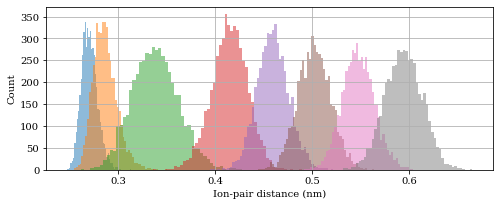

In [29]:
pullx_data = [np.transpose(np.loadtxt(f'sim_{i}/pullx.xvg', comments=['@', '#'])) for i in range(8)]
dist_list = [data[1] for data in pullx_data]

plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

As shown above, there is always overlap between neighboring windows, indicating that a force constant of 8000 $\mathrm{kJ/mol/nm^2}$ is reasonable. 
- If the force constant were too large, the spread of each distribution would have been too narrow, so there would be a risk of not having overlap between some of the neighboring replicas. 
- If the force constant were too small, it would be hard to keep the pull group at the desired center of the window. In this case, the pull group will drift to the metastable state, which could also lead to insufficient overlap. 

We will discuss this topic more in depth in Exercise 4, since this notebook has already been a little lengthy. 😃 

**Question 1**: How can we futher improve the overlap between neighboring distributions?

**Answer**: There are two possible workarounds:
- Add one or more windows to the region where there is less overlap.
- For the distribution drifting away from its desired center, we can increase the force constant for the corresponding harmonic potential so the configuration is better fixed. (Note that it is not required that we use the same force constant for all harmonic potentials.)

## 3. Computation of the free energy surface using MBAR

In [ ]:
import time
import pymbar
from pymbar import timeseries
import random
import scipy.stats

t0 = time.time()

# Step 1: Setting up
K = 8                                       # number of umbrellas
N_max = 5001                                # number of data points in each timeseries of ion-pair distance
kT = 1.381e-23 * 6.022e23 / 1000 * 300      # 1 kT converted to kJ/mol at 300 K
beta_k = np.ones(K) / kT                    # inverse temperature of simulations (in 1/(kJ/mol)) 
d_min, d_max = 0.25, 0.65                   # minimum and maximum of the CV for plotting the FES
nbins = 50                                  # number of bins for FES
K_k = np.ones(K) * 8000                     # spring constant (in kJ/mol/nm**2) for different simulations
N_k, g_k = np.zeros(K, int), np.zeros(K)    # number of samples and statistical inefficiency of different simulations
d_kn = np.zeros([K, N_max])                 # d_kn[k,n] is the ion-pair distance (in nm) for snapshot n from umbrella simulation k
u_kn = np.zeros([K, N_max])                 # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
uncorrelated_samples = []                   # Uncorrelated samples of different simulations

# Step 2: Read in and subsample the timeseries
for k in range(K):
    d_kn[k] = np.transpose(np.loadtxt(f'sim_{k}/pullx.xvg', comments=['@', '#']))[1]
    N_k[k] = len(d_kn[k])
    d_temp = d_kn[k, 0:N_k[k]]
    g_k[k] = timeseries.statistical_inefficiency(d_temp)     
    print(f"Statistical inefficiency of simulation {k}: {g_k[k]:.3f}")
    indices = timeseries.subsample_correlated_data(d_temp, g=g_k[k]) # indices of the uncorrelated samples
    
    # Update u_kn and d_kn with uncorrelated samples
    N_k[k] = len(indices)    # At this point, N_k contains the number of uncorrelated samples for each state k                
    u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    d_kn[k, 0:N_k[k]] = d_kn[k, indices]
    uncorrelated_samples.append(d_kn[k, indices])

d0_k = np.array([d_kn[i][0] for i in range(K)])    
N_max = np.max(N_k) # shorten the array size
u_kln = np.zeros([K, K, N_max]) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kn -= u_kn.min()  # shift the minimum of the FES to 0

# Step 3: Bin the data
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(d_min, d_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
   
# Step 4: Evaluate reduced energies in all umbrellas
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image ion-pair distance deviation from umbrella center l
        dd = d_kn[k,n] - d0_k  # delta d

        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k / 2) * dd ** 2

# Step 5: Compute, output, and plot the FES
fes = pymbar.FES(u_kln, N_k, verbose=False)
histo_params = {'bin_edges': bin_edges}
d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)
fes.generate_fes(u_kn, d_n, fes_type='histogram', histogram_parameters=histo_params)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
f_i = results["f_i"]
df_i = results["df_i"]

with open('fes.dat', 'w') as f:
    f.write("# free energy profile (in units of kT), from histogramming\n")
    f.write(f"# {'bin':>8s} {'f':>8s} {'df':>8s} \n")
    for i in range(nbins):
       f.write(f"{bin_center_i[i]:>8.3f} {f_i[i]:>8.3f} {df_i[i]:>8.3f} \n")

plt.figure()
plt.plot(bin_center_i, f_i)
plt.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.grid()

t1 = time.time()
print(f'\nTime elapsed: {t1 - t0:.0f} seconds.')

**Question 2**: Why is the uncertainty lower in some of the regions?

**Answer**: As shown above, the time series in different windows have different statistical inefficiencies/correlation times, hence different numbers of uncorrelated samples. Regions with a agreater number of uncorrelated samples typically have lower uncertainty, and vice versa.

In [ ]:
plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(uncorrelated_samples[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

## Reference(s)
- The paper that proposed MBAR: [Shirts, Michael R., and John D. Chodera. "Statistically optimal analysis of samples from multiple equilibrium states." The Journal of chemical physics 129.12 (2008): 124105.](https://aip.scitation.org/doi/abs/10.1063/1.2978177)
- Another perspective of interpreting the theory of MBAR: [Shirts, Michael R. "Reweighting from the mixture distribution as a better way to describe the Multistate Bennett Acceptance Ratio." arXiv preprint arXiv:1704.00891 (2017).](https://arxiv.org/abs/1704.00891)
- A review about umbrella sampling: [Kästner, Johannes. "Umbrella sampling." Wiley Interdisciplinary Reviews: Computational Molecular Science 1.6 (2011): 932-942.](https://doi.org/10.1002/wcms.66)

## Takeaways

- Umbrella sampling is composed of 2 steps:
  - Pulling simulation: A simulation that is used to generate configurations at different CV values.
  - Production runs: A bunch of simulations that fix configurations at different CV values to force the exploration of the CV space.

- The force constant for the pulling simulation does not really matter as long as it is strong enough to pull the pull group away.
- The force constant for the productions should be large enough to pin down the configurations but small enough to have wide probability distributions for each configuration.

- We decorrelate samples before performing MBAR. 
- MBAR can estimate the free energy surface as a function of the chosen CV rigorously. 